In [7]:
import geopandas as gpd
from src.data.fire_perimeters import FirePerimeters, FirePerimetersDB, Fire, match_gedi_to_raster, FireRastersDB
from src.visualization import ee_viz
from src.data import mtbs
from src.data import shape_processor
from src.data import gedi_pipeline
from src.data import k_nn
import ee
import scipy.stats as stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import *
from fitter import Fitter, get_common_distributions, get_distributions
from src.processing.recent_fires import gedi_matching, matching_analysis
from src.visualization.gedi_viz import geo_plot

import importlib
importlib.reload(gedi_pipeline)
importlib.reload(gedi_matching)
importlib.reload(matching_analysis)
from src.data.gedi_pipeline import get_severity

2023-06-05 21:16:23,831 DEBUG: Logger /home/jk871/fire-regen/src/data/gedi_pipeline.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]


In [2]:
ee.Authenticate()


Successfully saved authorization token.


In [3]:
ee.Initialize()

In [4]:
sierras = gpd.read_file("../../../data/shapefiles/sierras_convex_hull.shp")
firep_db = FirePerimetersDB('../../../data/fire_perimeters.gdb/')
sierra_firep = FirePerimeters(firep_db).filter_for_years(['2021']).filter_within_geometry(sierras)

In [6]:
gedi_gdf= gedi_pipeline.get_gedi_as_gdp('/maps/fire-regen/data/sierras_matched_lc_all_2x2.csv')
gedi_burned, gedi_unburned = gedi_pipeline.process_gedi_shots_for_recent_fires_analysis(gedi_gdf)

2023-06-05 21:07:16,631 DEBUG: Excluded shots on the burn boundaries, shots remaining:         9446235 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:58]
2023-06-05 21:07:16,948 DEBUG: Number of GEDI shots that burned at least once:                  1440937 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:63]
2023-06-05 21:07:18,376 DEBUG: Number of GEDI shots that never burned since 1984:         7852535 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:70]
2023-06-05 21:07:18,748 DEBUG: Number of shots that burned exactly once:                    1253729 [in exclude_shots_on_burn_boundaries at /home/jk871/fire-regen/src/data/gedi_pipeline.py:86]
2023-06-05 21:07:18,918 DEBUG: Number of GEDI shots that have a perfect match with burn                    raster (all 2x2 pixels have the same severity):                    771977 [in exclude_shots_on_burn_b

In [20]:
gedi_l2b = gedi_pipeline.get_gedi_as_gdp('/maps/fire-regen/data/gedi_l2b_sierras_matched_lc_all_2x2.csv')
gedi_burned_l2b, gedi_unburned_l2b = gedi_pipeline.process_gedi_shots_for_recent_fires_analysis(gedi_l2b)

2023-06-05 21:47:42,624 DEBUG: Excluded shots on the burn boundaries, shots remaining:         14968077 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:58]
2023-06-05 21:47:43,176 DEBUG: Number of GEDI shots that burned at least once:                  2184975 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:63]
2023-06-05 21:47:45,701 DEBUG: Number of GEDI shots that never burned since 1984:         12539296 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:70]
2023-06-05 21:47:46,645 DEBUG: Number of shots that burned exactly once:                    1891695 [in exclude_shots_on_burn_boundaries at /home/jk871/fire-regen/src/data/gedi_pipeline.py:86]
2023-06-05 21:47:47,039 DEBUG: Number of GEDI shots that have a perfect match with burn                    raster (all 2x2 pixels have the same severity):                    1192212 [in exclude_shots_on_bur

In [9]:
fire = sierra_firep.get_fire('KNP Complex')

In [10]:
matches = gedi_matching.match_measurements_before_and_after_fire(fire, gedi_burned, 'agbd')

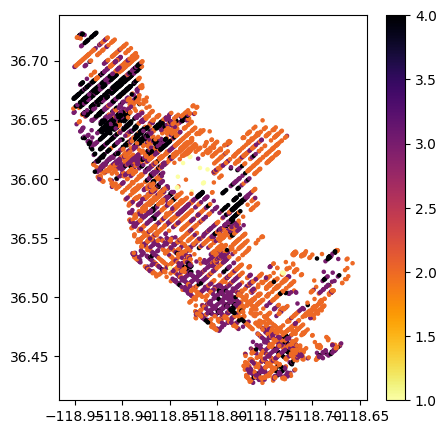

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
geo_plot(matches, ax, 'burn_severity_median', vmin=1, vmax=4)

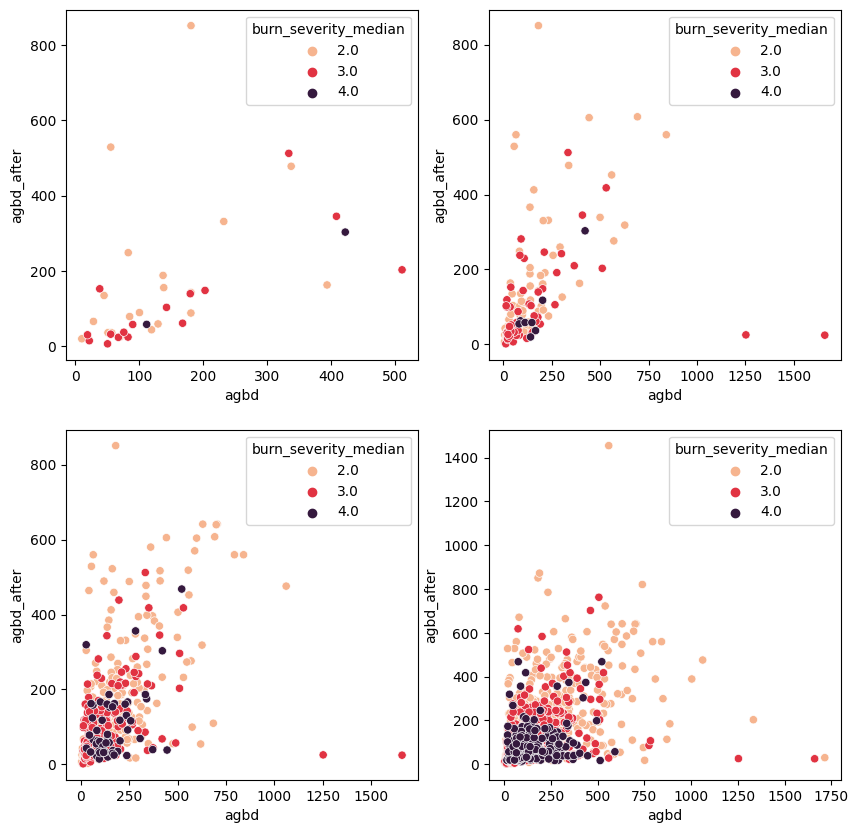

In [11]:
matching_analysis.plot_severity_for_distance(matches, 'agbd')

/maps-priv/maps/fire-regen/fire-regen-env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


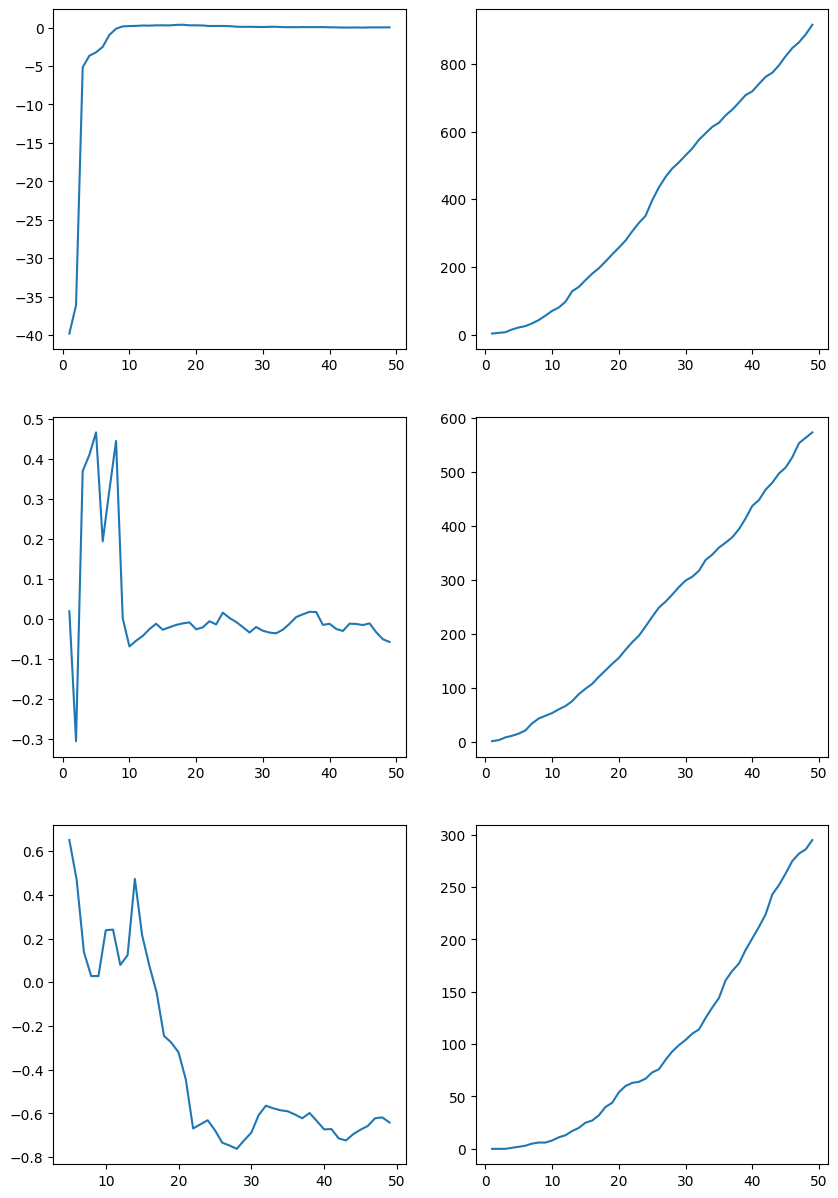

In [13]:
matching_analysis.plot_error_for_distances(matches, 'agbd')

In [15]:
def filter_land_cover(df):
    return df[(df.land_cover_std == 0) & (df.land_cover_mean == 1) & (df.pft_class == 1)]

In [16]:
close_matches = filter_land_cover(matches[matches.closest_distance < 20])

Linear regression fit for severity 2.
Best Linear regression coefficient is [0.50661762].         R squared is : 0.34078864908726225.
The error for coeff = 1 is: 0.24761681922112178.
Linear regression fit for severity 3.
Best Linear regression coefficient is [0.06393206].         R squared is : 0.020268953860352767.
The error for coeff = 1 is: -0.14027962247761572.
Linear regression fit for severity 4.
Best Linear regression coefficient is [0.37052408].         R squared is : 0.194567098628585.
The error for coeff = 1 is: -0.282923965039094.


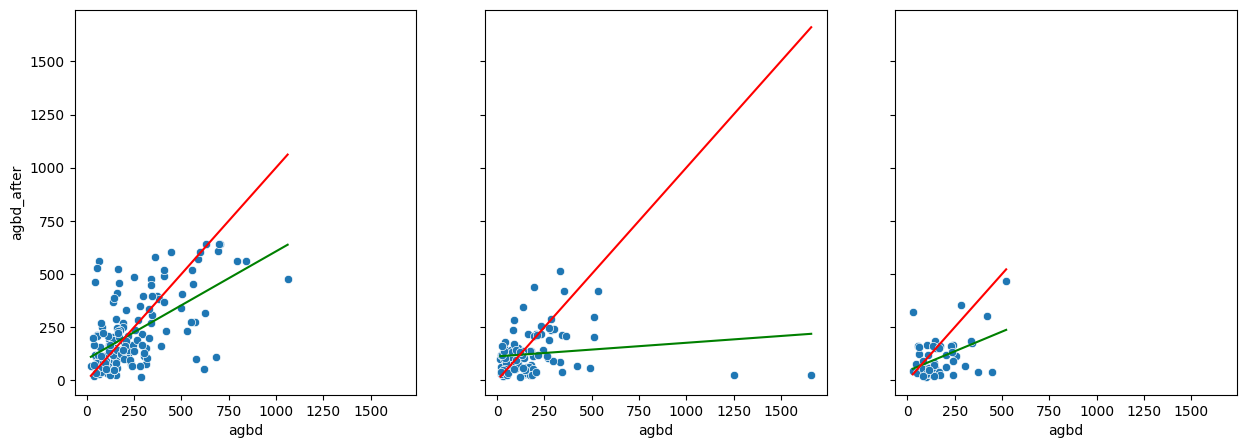

In [17]:
matching_analysis.fit_linear_regression_per_severity(close_matches, 'agbd')

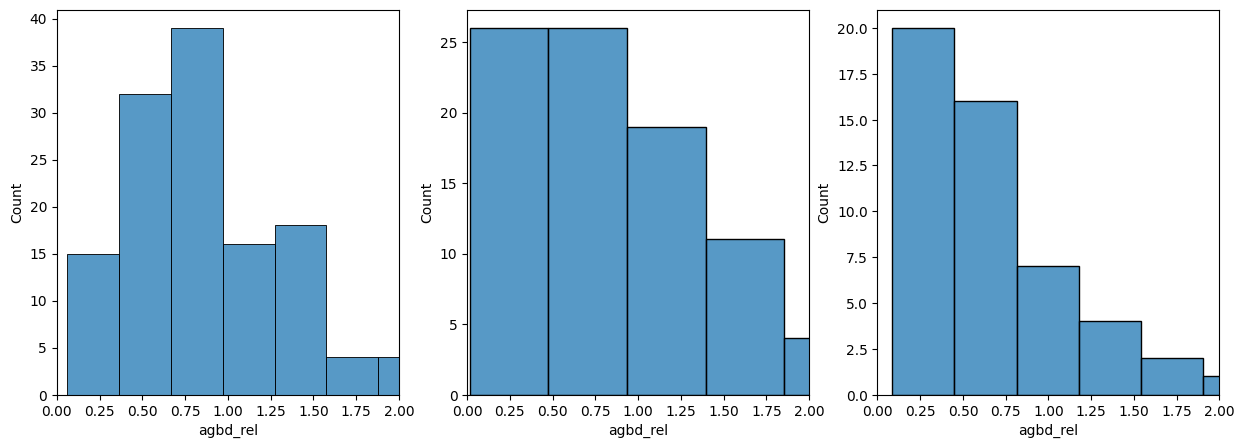

In [18]:
matching_analysis.plot_rel_difference_per_severity(close_matches, 'agbd')

### Fit distribution

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00,  7.81it/s]


         sumsquare_error          aic          bic  kl_div  ks_statistic  \
beta            0.000108  1986.092702 -3829.762972     inf      0.132034   
lognorm         0.000111  1983.623418 -3828.126575     inf      0.144632   
norm            0.000111  1974.023613 -3833.581790     inf      0.141446   
gamma           0.000120  1954.524668 -3807.513399     inf      0.157948   
burr            0.000642  1774.420676 -3362.631326     inf      0.684160   

             ks_pvalue  
beta      1.919864e-04  
lognorm   3.021378e-05  
norm      4.900797e-05  
gamma     3.553446e-06  
burr     2.183429e-122  


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 28.69it/s]


{'norm': {'loc': 2.6221714383773223, 'scale': 108.48552210144572}}


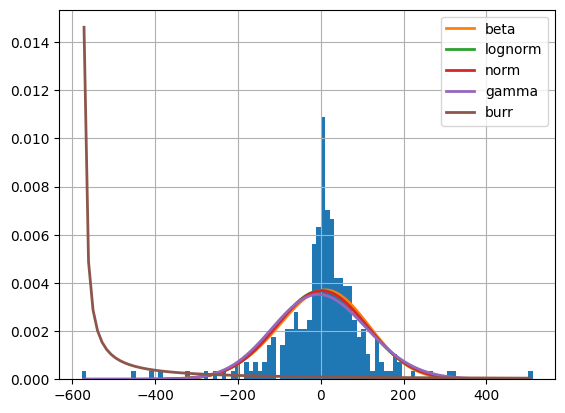

In [110]:
matching_analysis.fit_distributions(get_severity(close_matches, 2), 'agbd')

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 10.54it/s]


         sumsquare_error          aic          bic  kl_div  ks_statistic  \
beta            0.000266  1767.008263 -1293.035893     inf      0.167121   
gamma           0.000267  1762.619606 -1297.111658     inf      0.180129   
norm            0.000269  1744.890709 -1300.930152     inf      0.163681   
lognorm         0.000812  1786.937967 -1183.688523     inf      0.794762   
burr            0.000874  1751.699845 -1171.540699     inf      0.709107   

            ks_pvalue  
beta     5.857730e-03  
gamma    2.285866e-03  
norm     7.423164e-03  
lognorm  1.566999e-69  
burr     3.339677e-52  


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 27.23it/s]


{'norm': {'loc': 58.31384722391764, 'scale': 112.2860504110404}}


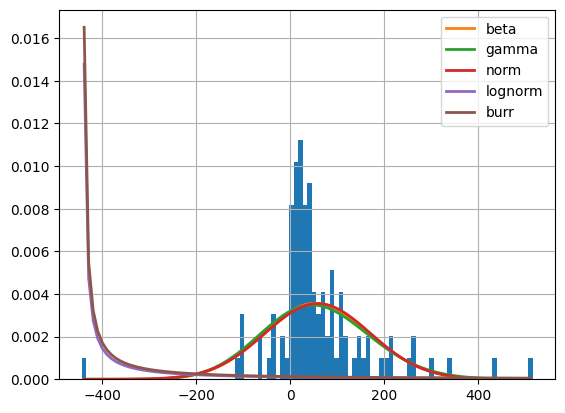

In [111]:
matching_analysis.fit_distributions(get_severity(close_matches, 3), 'agbd')

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00, 11.43it/s]


         sumsquare_error          aic         bic  kl_div  ks_statistic  \
gamma           0.000464  1398.153034 -530.151665     inf      0.065442   
beta            0.000464  1399.461188 -526.281678     inf      0.065739   
norm            0.000534  1441.930547 -527.378116     inf      0.151840   
lognorm         0.001630  1678.831472 -471.094045     inf      0.699866   
burr            0.001739  1618.662475 -464.218613     inf      0.535917   

            ks_pvalue  
gamma    9.799540e-01  
beta     9.790537e-01  
norm     2.064718e-01  
lognorm  1.342721e-23  
burr     3.806278e-13  


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 30.08it/s]


{'norm': {'loc': 129.4534209839841, 'scale': 124.69034455144067}}


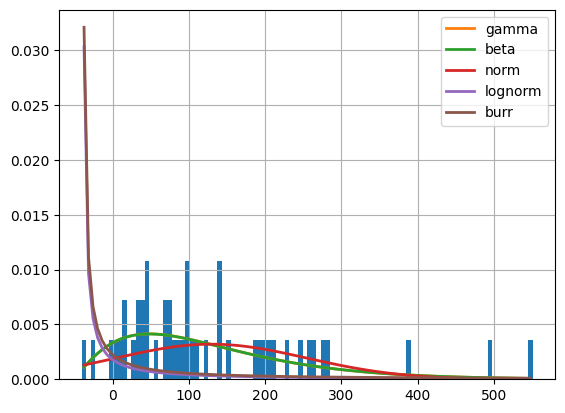

In [112]:
matching_analysis.fit_distributions(get_severity(close_matches, 4), 'agbd')

### Stat tests

In [113]:
matching_analysis.two_sided_tests(get_severity(close_matches, 2), 'agbd')

Shapiro test results ShapiroResult(statistic=0.8801906704902649, pvalue=1.7245307558279993e-13)
Ttest results: TtestResult(statistic=0.3904896729450677, pvalue=0.6964930095722461, df=261)
Wilcoxon test results: WilcoxonResult(statistic=14759.0, pvalue=0.04445149416606761)


In [114]:
matching_analysis.two_sided_tests(get_severity(close_matches, 3), 'agbd')

Shapiro test results ShapiroResult(statistic=0.8467029333114624, pvalue=6.995472201509756e-09)
Ttest results: TtestResult(statistic=5.219231680552508, pvalue=9.630272752752117e-07, df=101)
Wilcoxon test results: WilcoxonResult(statistic=773.0, pvalue=6.119563423832334e-10)


In [115]:
matching_analysis.two_sided_tests(get_severity(close_matches, 4), 'agbd')

Shapiro test results ShapiroResult(statistic=0.8745905756950378, pvalue=0.0001224538718815893)
Ttest results: TtestResult(statistic=7.041409835832142, pvalue=7.898174912656163e-09, df=46)
Wilcoxon test results: WilcoxonResult(statistic=19.0, pvalue=4.362732397567015e-12)


In [21]:
from src.data import pai_vertical
importlib.reload(gedi_matching)
importlib.reload(pai_vertical)

<module 'src.data.pai_vertical' from '/home/jk871/fire-regen/src/data/pai_vertical.py'>

In [22]:
matches_paiz = gedi_matching.match_pai_z_before_and_after_fire(fire, gedi_burned_l2b)

Index(['shot_number', 'absolute_time', 'lon_lowestmode', 'lat_lowestmode',
       'fhd_normal', 'pai', 'pai_z', 'pavd_z', 'rh100', 'cover', 'cover_z',
       'beam_type', 'sensitivity', 'gridded_pft_class', 'geometry',
       'burn_severity_2x2', 'burn_severity_mean', 'burn_severity_std',
       'burn_severity_median', 'burn_year_2x2', 'burn_year_mean',
       'burn_year_std', 'burn_year_median', 'burn_counts_2x2',
       'burn_counts_mean', 'burn_counts_std', 'burn_counts_median',
       'land_cover_2x2', 'land_cover_mean', 'land_cover_std',
       'land_cover_median', 'gedi_year', 'gedi_month', 'time_since_burn',
       'index_right', 'YEAR_', 'STATE', 'AGENCY', 'UNIT_ID', 'FIRE_NAME',
       'INC_NUM', 'ALARM_DATE', 'CONT_DATE', 'CAUSE', 'COMMENTS', 'REPORT_AC',
       'GIS_ACRES', 'C_METHOD', 'OBJECTIVE', 'FIRE_NUM', 'Shape_Length',
       'Shape_Area', 'COMPLEX_NAME', 'COMPLEX_INCNUM', 'FID', 'pai_z_np',
       'pai_z_padded', 'pai_z_delta_np'],
      dtype='object')
1
2
3


In [23]:
def l2b_filter_land_cover(df):
    return df[(df.land_cover_std == 0) & (df.land_cover_mean == 1)]
close_matches = l2b_filter_land_cover(matches_paiz[matches_paiz.closest_distance < 20])

In [24]:
def get_pai_z_df(df, severity):
    lala = get_severity(df, severity).pai_z_delta_diff.to_numpy()
    new_lala = np.empty((lala.shape[0], lala[0].shape[0]))

    for i in range(lala.shape[0]):
        new_lala[i] = lala[i]

    return pd.melt(pd.DataFrame(new_lala))

(0.0, 13.0)

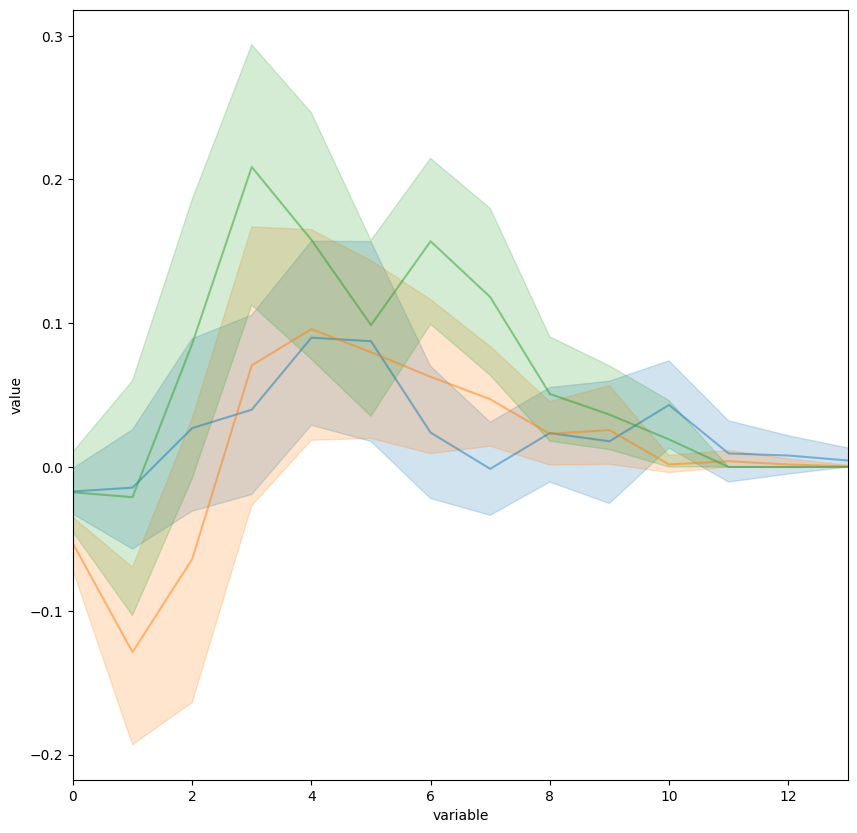

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.lineplot(get_pai_z_df(close_matches, 2), x='variable', y='value', ax=ax, alpha=0.5)
sns.lineplot(get_pai_z_df(close_matches, 3), x='variable', y='value', ax=ax, alpha=0.5)
sns.lineplot(get_pai_z_df(close_matches, 4), x='variable', y='value', ax=ax, alpha=0.5)
ax.set_xlim((0, 13))